In [ ]:
from utils import *

NOTEBOOK_ID = '06'
RUN_GRID_SEARCH = False
RUN_TPE_SEARCH = False

# perform grid search

In [ ]:
if RUN_GRID_SEARCH:
    out_dir = f'{PARAMETER_DIR}/01-grid_search'
    input_df = pd.read_pickle(f'{EMBEDDING_DIR}/esm2_t33_650M_UR50D-layer33-representations.pkl')
    X = np.asarray([np.array(emb) for emb in input_df[f'esm2_t33_650M_UR50D']])
    activity = input_df['activity'].to_numpy()
    thresh = input_df['activity'].median()
    y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)
    y_cont = activity.reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(y_cont)
    y_cont = scaler.transform(y_cont)
    train, val, test, _ = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
    (X_train, y_bin_train, y_cont_train) = train
    (X_val, y_bin_val, y_cont_val) = val
    (X_test, y_bin_test, y_cont_test) = test

    train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
    val_ds = TensorDataset(X_val.to(torch.float), y_cont_val.to(torch.float))
    param_combinations = list(itertools.product(*PARAMS.values()))
    with open('parameter_sweep.txt','a') as out_file:
        for idx, combination in enumerate(param_combinations):
            params = dict(zip(PARAMS.keys(), combination))
            OUTPUT_FILE = f"cnn_h{params['hidden_size']}_k{params['kernel_size']}_d{params['dilation']}_r{params['num_res_blocks']}_b{params['batch_size']}"

            train_dl = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=False)
            val_dl = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False)

            model = ADhunter_v2(
                embedding_size=EMBEDDING_SIZE,
                seq_len=SEQ_LEN,
                hidden=params['hidden_size'], 
                kernel_size=params['kernel_size'], 
                dilation=params['dilation'], 
                num_res_blocks=params['num_res_blocks'],
                )
            model = model.float()
            csv_logger = CSVLogger(f"{out_dir}/01-logs",name=OUTPUT_FILE,version='')
            checkpoint_callback = ModelCheckpoint(dirpath=f"{out_dir}/02-models", monitor="val_loss", filename=OUTPUT_FILE, save_last=False)
            early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
            trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCH)
            trainer.fit(model.to("cuda"), train_dataloaders=train_dl, val_dataloaders=val_dl)

            model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
            torch.save(model.cpu().state_dict(), f'{out_dir}/02-models/{OUTPUT_FILE}.pt')

            model = ADhunterSystem_v2(
                embedding_size=X[0].shape[1],
                seq_len=X[0].shape[0],
                hidden=params['hidden_size'], 
                kernel_size=params['kernel_size'], 
                dilation=params['dilation'], 
                num_res_blocks=params['num_res_blocks'],
                )
            model.load_state_dict(torch.load(f'{out_dir}/02-models/{OUTPUT_FILE}.pt'))

            model.eval()
            X_test, y_test = X_test, y_cont_test
            y_test = y_test.reshape(-1)
            with torch.no_grad():
                y_test_hat = model(X_test).reshape(-1)
                y_test_hat = y_test_hat.detach().numpy()
                y_test = y_test.numpy()

            best_thresh = get_threshold(y_bin_test, y_test_hat)
            best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
            y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

            y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
            y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

            pearson_corr = pearsonr(y_test_hat_unscaled, y_test_unscaled).correlation
            out_file.write(f"run {idx}: {repr(combination)}\t Pearson: {pearson_corr:4f}\n")

# evaluate grid search

In [4]:
out_file = f'{PARAMETER_DIR}/01-grid_search/03-results/parameter_sweep_results.csv'
if not os.path.isfile(out_file):
    top_df = pd.read_csv(f'{PARAMETER_DIR}/01-grid_search/03-results/parameter_sweep.txt',header=None)
    top_df['run'] = top_df[0].apply(lambda x: x.split(':')[0].split('run ')[-1]).astype(int)
    top_df['hidden_size'] = top_df[0].apply(lambda x: x.split(': (')[-1]).astype(int)
    top_df['pearson'] = top_df[4].apply(lambda x: x.split('Pearson: ')[-1]).astype(float)
    top_df['batch_size'] = top_df[4].apply(lambda x: x.split(')\t Pearson: ')[0]).astype(int)
    top_df = top_df.drop(columns=[0,4]).rename(columns={1:'kernel_size',2:'dilation',3:'num_res_blocks'})
    top_df['kernel_size'] = top_df['kernel_size'].astype(int)
    top_df['dilation'] = top_df['dilation'].astype(int)
    top_df['num_res_blocks'] = top_df['num_res_blocks'].astype(int)
    top_df = top_df[['run','hidden_size','kernel_size','dilation','num_res_blocks','batch_size','pearson']]
    # top_df = top_df.query('pearson >= 0.80')
    top_df['file'] = 'cnn_h' + top_df['hidden_size'].astype(str) + '_k' + top_df['kernel_size'].astype(str) + '_d' + top_df['dilation'].astype(str) + '_r' + top_df['num_res_blocks'].astype(str) + '_b' + top_df['batch_size'].astype(str)
    top_df = top_df.reset_index(drop=True)
    top_df.to_csv(out_file,index=False)
else:
    top_df = pd.read_csv(out_file)
top_df

,run,hidden_size,kernel_size,dilation,num_res_blocks,batch_size,pearson,file
0,0,32,3,3,0,32,0.779096,cnn_h32_k3_d3_r0_b32
1,1,32,3,3,0,64,0.782045,cnn_h32_k3_d3_r0_b64
2,2,32,3,3,0,128,0.768414,cnn_h32_k3_d3_r0_b128
3,0,32,3,3,0,32,0.760842,cnn_h32_k3_d3_r0_b32
4,1,32,3,3,0,64,0.783242,cnn_h32_k3_d3_r0_b64
...,...,...,...,...,...,...,...,...
11263,11260,256,4,7,8,32,0.769935,cnn_h256_k4_d7_r8_b32
11264,11261,256,4,7,8,64,0.766922,cnn_h256_k4_d7_r8_b64
11265,11262,256,4,7,8,128,0.767213,cnn_h256_k4_d7_r8_b128
11266,11263,256,4,7,8,256,0.777339,cnn_h256_k4_d7_r8_b256


In [5]:
out_file = f'{PARAMETER_DIR}/01-grid_search/03-results/metrics_df.csv'
if not os.path.isfile(out_file):
    metrics_df = None
    for file in tqdm([f for f in glob(f'{PARAMETER_DIR}/01-grid_search/01-logs/cnn_h*/*.csv') if f.split('/')[-2] in df['file'].unique()]):
        handle = file.split('/')[-2].replace('.csv','')
        tmp_df = pd.read_csv(file)
        tmp_df = tmp_df.groupby('epoch').max().reset_index()
        tmp_df['trial'] = handle
        metrics_df = pd.concat([metrics_df,tmp_df])
        del tmp_df
    metrics_df = metrics_df.reset_index(drop=True)
    metrics_df['hidden_size'] = metrics_df['trial'].apply(lambda x: x.split('_')[1].replace('h','')).astype(int)
    metrics_df['kernel_size'] = metrics_df['trial'].apply(lambda x: x.split('_')[2].replace('k','')).astype(int)
    metrics_df['dilation'] = metrics_df['trial'].apply(lambda x: x.split('_')[3].replace('d','')).astype(int)
    metrics_df['num_res_blocks'] = metrics_df['trial'].apply(lambda x: x.split('_')[4].replace('r','')).astype(int)
    metrics_df['batch_size'] = metrics_df['trial'].apply(lambda x: x.split('_')[5].replace('b','')).astype(int)
    metrics_df.to_csv(out_file,index=False)
else:
    metrics_df = pd.read_csv(out_file)
metrics_df

,epoch,val_loss,val_rmse,val_pearsonr,val_spearmanr,step,train_rmse,train_pearsonr,train_spearmanr,trial
0,0,0.738338,0.738338,0.720815,0.717558,55,0.817585,0.574865,0.573079,cnn_h128_k3_d6_r3_b256
1,1,0.788194,0.788194,0.733186,0.736075,111,0.673212,0.737011,0.735815,cnn_h128_k3_d6_r3_b256
2,2,0.714239,0.714239,0.759302,0.763168,167,0.681754,0.729108,0.731104,cnn_h128_k3_d6_r3_b256
3,3,0.695839,0.695839,0.767749,0.773873,223,0.637103,0.768790,0.770342,cnn_h128_k3_d6_r3_b256
4,4,0.806338,0.806338,0.770900,0.780677,279,0.613509,0.787750,0.788107,cnn_h128_k3_d6_r3_b256
...,...,...,...,...,...,...,...,...,...,...
1898,9,0.669753,0.669753,0.777359,0.783693,279,0.544744,0.837480,0.832145,cnn_h64_k8_d4_r1_b512
1899,10,0.649526,0.649526,0.787142,0.785254,307,0.525199,0.850651,0.847382,cnn_h64_k8_d4_r1_b512
1900,11,0.695865,0.695865,0.781441,0.780019,335,0.538897,0.841282,0.834923,cnn_h64_k8_d4_r1_b512
1901,12,0.622680,0.622680,0.788699,0.795054,363,0.531645,0.845947,0.839757,cnn_h64_k8_d4_r1_b512


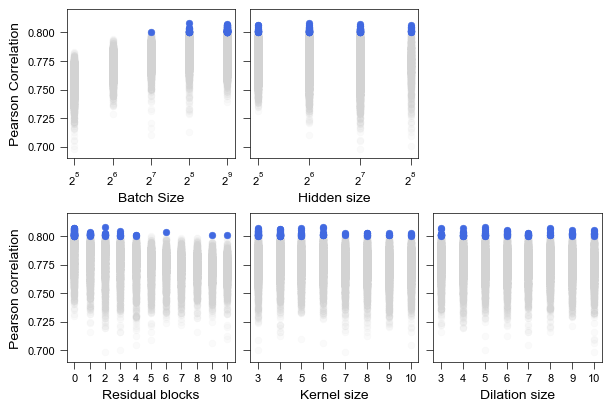

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(6,4),constrained_layout=True,sharey=True)

g = sns.scatterplot(data=top_df.query('pearson < 0.80'),x='batch_size',y='pearson',color='lightgray',legend=False,ax=axes[0,0],edgecolor=None,alpha=0.1)
g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='batch_size',y='pearson',color='royalblue',legend=False,ax=axes[0,0],edgecolor=None)
g.set(xlabel='Batch Size',ylabel='Pearson Correlation')
axes[0,0].set_xscale('log', base=2)
g.set_xticks(PARAMS['batch_size'])

g = sns.scatterplot(data=top_df.query('pearson < 0.80'),x='hidden_size',y='pearson',color='lightgray',legend=False,ax=axes[0,1],alpha=0.1,edgecolor=None)
g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='hidden_size',y='pearson',color='royalblue',legend=False,ax=axes[0,1],edgecolor=None)
g.set(xlabel='Hidden size',ylabel='Pearson correlation')
axes[0,1].set_xscale('log', base=2)
g.set_xticks([32, 64, 128, 256])
axes[0,2].axis('off')

g = sns.scatterplot(data=top_df.query('pearson < 0.80'),x='num_res_blocks',y='pearson',color='lightgray',legend=False,ax=axes[1,0],edgecolor=None,alpha=0.1)
g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='num_res_blocks',y='pearson',color='royalblue',legend=False,ax=axes[1,0],edgecolor=None)
g.set(xlabel='Residual blocks',ylabel='Pearson correlation')
g.set_xticks(PARAMS['num_res_blocks'])
g.set_ylim(0.69,0.82)

g = sns.scatterplot(data=top_df.query('pearson < 0.80'),x='kernel_size',y='pearson',color='lightgray',legend=False,ax=axes[1,1],alpha=0.1,edgecolor=None)
g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='kernel_size',y='pearson',color='royalblue',legend=False,ax=axes[1,1],edgecolor=None)
g.set(xlabel='Kernel size',ylabel='Pearson correlation')
g.set_xticks(PARAMS['kernel_size'])

g = sns.scatterplot(data=top_df.query('pearson < 0.80'),x='dilation',y='pearson',color='lightgray',legend=False,ax=axes[1,2],alpha=0.1,edgecolor=None)
g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='dilation',y='pearson',color='royalblue',legend=False,ax=axes[1,2],edgecolor=None)
g.set(xlabel='Dilation size',ylabel='Pearson correlation')
g.set_xticks(PARAMS['dilation'])

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-parameter_optimization.png',**FIGURE_PARAMS)

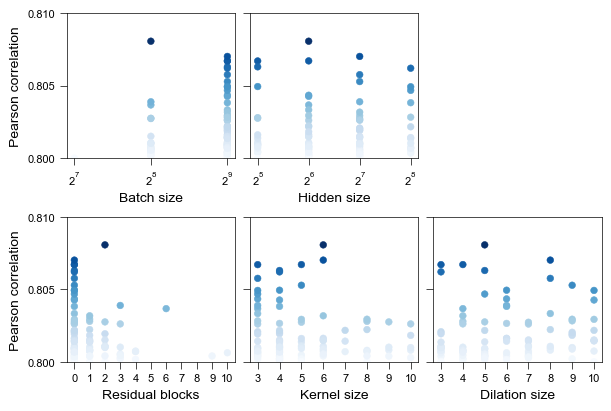

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(6,4),constrained_layout=True,sharey=True)

g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='batch_size',y='pearson',hue='pearson',legend=False,palette=sns.color_palette('Blues',as_cmap=True),ax=axes[0,0],edgecolor=None)
g.set(xlabel='Batch size',ylabel='Pearson correlation')
g.set_xticks(PARAMS['batch_size'])
axes[0,0].set_xscale('log', base=2)

g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='hidden_size',y='pearson',hue='pearson',legend=False,palette=sns.color_palette('Blues',as_cmap=True),ax=axes[0,1],edgecolor=None)
g.set(xlabel='Hidden size',ylabel='Pearson correlation')
g.set_xticks([32, 64, 128, 256])
axes[0,1].set_xscale('log', base=2)
axes[0,2].axis('off')

g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='num_res_blocks',y='pearson',hue='pearson',legend=False,palette=sns.color_palette('Blues',as_cmap=True),ax=axes[1,0],edgecolor=None)
g.set(xlabel='Residual blocks',ylabel='Pearson correlation')
g.set_xticks(PARAMS['num_res_blocks'])
g.set_ylim(0.80,0.81)
g.set_yticks([0.80,0.805,0.810])

g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='kernel_size',y='pearson',hue='pearson',legend=False,palette=sns.color_palette('Blues',as_cmap=True),ax=axes[1,1],edgecolor=None)
g.set(xlabel='Kernel size',ylabel='Pearson correlation')
g.set_xticks(PARAMS['kernel_size'])

g = sns.scatterplot(data=top_df.query('pearson >= 0.80'),x='dilation',y='pearson',hue='pearson',legend=False,palette=sns.color_palette('Blues',as_cmap=True),ax=axes[1,2],edgecolor=None)
g.set(xlabel='Dilation size',ylabel='Pearson correlation')
g.set_xticks(PARAMS['dilation'])

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-parameter_optimization_filtered.png',**FIGURE_PARAMS)

# perform TPE using Optuna

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [ ]:
if RUN_TPE_SEARCH:
    sampler = optuna.samplers.TPESampler()    
    study = optuna.create_study(
        study_name='ADhunter_v2_optimization',
        sampler=sampler,
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=10, n_warmup_steps=20, interval_steps=5
        ),
        direction='maximize',
        storage=f"sqlite://{PARAMETER_DIR}/03-optuna_ADhunter_v2/db.sqlite3")
    study.optimize(func=objective, n_trials=10_000)
    study.trials_dataframe().to_csv(f"{PARAMETER_DIR}/03-optuna_ADhunter_v2/optuna_study_results.csv",index=False)

    optuna.visualization.plot_slice(study)
    optuna.visualization.plot_param_importances(study)